# DeepSurv

## Init

https://nbviewer.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb

In [ ]:
# ! pip install sklearn-pandas

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
base = os.path.basename(os.getcwd())
list = os.getcwd().split(os.sep) 
list.pop(list.index(base))
ROOT = '\\'.join(list)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')

In [3]:
# available datasets:
#   clinical_miRNA_normalized_log.csv
#   clinical_miRNA_normalized_quant.csv
#   mRNA\\clinical_mRNA_normalized_log.csv
#   mRNA\\clinical_mRNA_normalized_tpm_log.csv
dataset = pd.read_csv(os.path.join(DATA_PATH, 'clinical_miRNA_normalized_log.csv'))

# set folder name for saving models: 
#   'miRNA_quant' for quantile normalized data
#   'miRNA_log' for log normalized data
#   'mRNA_log' for mRNA log normalized data
#   'mRNA_tpm_log' for mRNA TPM log normalized data
folder_name = 'miRNA_log'

In [ ]:
print(dataset.shape)
print(dataset.columns)

## Hyper-parameters

In [4]:
num_folds = 5
SEED = 42
WITH_CLINICAL = False  # If False, only miRNA/mRNA data will be used

In [5]:
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

## Data

In [6]:
dataset = dataset.rename(columns={'Death': 'event', 'days_to_last_followup': 'duration'})
dataset.drop(columns=['days_to_death'], inplace=True)

if not WITH_CLINICAL:
    # remove clinical data columns
    clinical_cols = [col for col in dataset.columns if not col.startswith('hsa') and col != 'duration' and col != 'event']
    dataset.drop(columns=clinical_cols, inplace=True)

## Data splitting

In [14]:
"""df_train = dataset.copy()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)"""

In [15]:
"""df_train.head()"""

,duration,event,hsa-mir-1-1,hsa-mir-1-2,hsa-mir-105-1,hsa-mir-105-2,hsa-mir-1179,hsa-mir-1181,hsa-mir-1185-1,hsa-mir-1185-2,...,hsa-mir-934,hsa-mir-935,hsa-mir-937,hsa-mir-938,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95
0,1918.0,0,1.538375,1.216571,-9.965784,-9.965784,-9.965784,0.217192,-9.965784,-9.965784,...,-9.965784,3.970930,2.538127,-9.965784,-0.781568,3.739620,1.216571,-9.965784,-9.965784,0.217192
3,212.0,0,0.698903,0.284162,-0.300209,-9.965784,-9.965784,-9.965784,-2.294887,-9.965784,...,-0.714655,3.426069,2.983599,-9.965784,1.283569,3.531029,1.946316,-9.965784,-0.714655,1.158093
4,2763.0,1,-1.406438,0.590692,0.175974,0.590692,-9.965784,-9.965784,-9.965784,-9.965784,...,-0.408349,3.049340,0.912428,-9.965784,-1.406438,3.233743,2.049514,-9.965784,-9.965784,2.175016
5,11.0,0,1.492429,1.077562,7.113978,7.273285,1.077562,-9.965784,-0.506033,-9.965784,...,-9.965784,-9.965784,-9.965784,-9.965784,1.077562,1.492429,2.492173,-9.965784,-0.506033,2.299564
6,27.0,0,1.004552,-0.801006,-9.965784,-0.801006,-9.965784,-9.965784,-9.965784,-9.965784,...,-9.965784,-0.801006,2.366682,-9.965784,0.519412,1.004552,1.656367,-9.965784,-1.798497,-0.216882


## Z-scaling

Note that PyTorch require variables of type 'float32'.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

scaler = StandardScaler()

cols_leave = [col for col in dataset.columns if col.startswith('pathologic')]
cols_standardize = [col for col in dataset.columns if col not in cols_leave + ['duration', 'event']]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [17]:
"""x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')"""

In [18]:
"""get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val"""

##### my

In [18]:
y = dataset[['duration', 'event']].copy()

scaled_X = pd.DataFrame(
    x_mapper.fit_transform(dataset).astype('float32'),
    columns=dataset.columns.drop(['duration', 'event'])
)

## Data splitting

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=SEED)

In [28]:
print("y_train mean/std:", np.mean(y_train.values), np.std(y_train.values, axis=0))
print("y_test mean/std:", np.mean(y_test.values), np.std(y_test.values, axis=0))

y_train mean/std: 379.74580536912754 [9.53599875e+02 2.77226705e-01]
y_test mean/std: 467.0566666666667 [1.04137163e+03 3.24961536e-01]


## K-fold

In [22]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

## Neural net

a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. Here, we just use the torchtuples.practical.MLPVanilla net to do this.

Note that we set out_features to 1, and that we have not output_bias.

In [48]:
"""in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)"""

In [57]:
class DeepSurvNet_3(nn.Module):
    def __init__(self, input_dim, num_nodes1=64, num_nodes2=32, dropout=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, num_nodes1),
            nn.BatchNorm1d(num_nodes1),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(num_nodes1, num_nodes2),
            nn.BatchNorm1d(num_nodes2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(num_nodes2, 1)
        )
        
    def forward(self, x):
        return self.model(x).squeeze(-1)
    
    
#in_features = x_train.shape[1]
in_features = scaled_X.shape[1]
net = DeepSurvNet_3(in_features)

a more complex net with more layers and different activations could be defined as follows

In [24]:
class DeepSurvNet_5(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 1)  # output: log hazard
        )

    def forward(self, x):
        return self.net(x)
                        
#in_features = x_train.shape[1]
in_features = scaled_X.shape[1]
net_5 = DeepSurvNet_5(in_features)

## Training the model

We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by Smith 2017 (https://arxiv.org/pdf/1506.01186) to find a suitable learning rate with model.lr_finder. See this post for an explanation.

In [25]:
model = CoxPH(net, tt.optim.Adam)
#model = CoxPH(net_5, tt.optim.Adam)

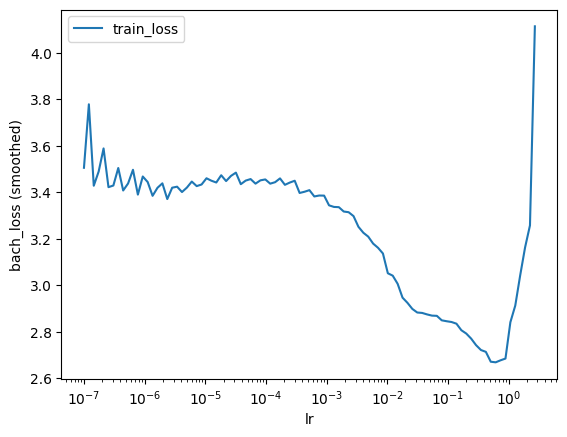

In [39]:
batch_size = 256

y_train_struct = (y_train['duration'].to_numpy(), y_train['event'].to_numpy())
#lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
lrfinder = model.lr_finder(X_train.to_numpy(), y_train_struct, batch_size, tolerance=10)
_ = lrfinder.plot()

In [40]:
lrfinder.get_best_lr()

np.float64(0.0613590727341321)

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [41]:
model.optimizer.set_lr(0.01)

We include the EarlyStopping callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [43]:
epochs = 512
verbose = True

from torchtuples.callbacks import EarlyStopping, LRScheduler

callbacks = [
    EarlyStopping(patience=10),
    LRScheduler(torch.optim.lr_scheduler.ReduceLROnPlateau)
]

TypeError: __init__() missing 1 required positional argument: 'mm_obj'

In [26]:
%%time
#log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.8103,	val_loss: 2.7839
1:	[0s / 0s],		train_loss: 3.4106,	val_loss: 2.8018
2:	[0s / 0s],		train_loss: 2.8876,	val_loss: 2.8271
3:	[0s / 0s],		train_loss: 2.5731,	val_loss: 2.8419
4:	[0s / 0s],		train_loss: 2.5519,	val_loss: 2.8772
5:	[0s / 0s],		train_loss: 2.3427,	val_loss: 3.0446
6:	[0s / 0s],		train_loss: 2.1294,	val_loss: 3.2650
7:	[0s / 0s],		train_loss: 2.1837,	val_loss: 3.4375
8:	[0s / 0s],		train_loss: 2.3055,	val_loss: 3.6076
9:	[0s / 0s],		train_loss: 2.1219,	val_loss: 3.6454
10:	[0s / 0s],		train_loss: 1.7907,	val_loss: 3.7322
CPU times: total: 406 ms
Wall time: 303 ms


#### Grid search + K-fold

In [74]:
from sklearn.model_selection import ParameterGrid
from torchtuples.callbacks import EarlyStopping

def create_model(input_dim, params):
    net = DeepSurvNet_3(input_dim,
                       num_nodes1=params['num_nodes_layer1'],
                       num_nodes2=params['num_nodes_layer2'],
                       dropout=params['dropout'])
    
    model = CoxPH(net, tt.optim.Adam)
    model.optimizer.set_lr(params['lr'])    
    return model

param_grid = {
    'num_nodes_layer1': [64],#, 128],  # primo layer
    'num_nodes_layer2': [32],#, 64],   # secondo layer
    'dropout': [0.1],#, 0.3, 0.5],
    'lr': [0.01],#, 0.001, 0.0001],
    'batch_size': [32],#, 64, 128],
    'epochs': [200],#, 500],
    'weight_decay': [1e-6],#, 1e-5],
    'callbacks__lr_scheduler__factor': [0.7]#, 0.5]
}

results = []

for params in ParameterGrid(param_grid):
    scores = []
    log = None
    X_val, y_val = None, None
    for train_index, val_index in kf.split(scaled_X):
        X_train, X_val = scaled_X.iloc[train_index], scaled_X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        y_train = (y_train['duration'].to_numpy(), y_train['event'].to_numpy())
        y_val = (y_val['duration'].to_numpy(), y_val['event'].to_numpy())
        
        X_train = X_train.to_numpy().astype('float32')
        X_val = X_val.to_numpy().astype('float32')
        
        model = create_model(X_train.shape[1], params)
        
        callbacks = [
            EarlyStopping(patience=10),
            #LRScheduler()
        ]
        
        log = model.fit(
            X_train,
            y_train,             
            batch_size=params['batch_size'],
            epochs=params['epochs'],
            callbacks=callbacks, 
            verbose = True, 
            val_data=(X_val, y_val), 
            val_batch_size=params['batch_size']
        )
        
        model.compute_baseline_hazards()        
        surv = model.predict_surv_df(X_val)
        ev = EvalSurv(surv, y_val[0], y_val[1], censor_surv='km')
        #ev = EvalSurv(surv, y_val[:,0], y_val[:,1], censor_surv='km')
        scores.append(ev.concordance_td())
        
    results.append({'params': params, 'mean_concordance': np.mean(scores), 'log': log, 'val': (X_val, y_val)})

best_result = max(results, key=lambda x: x['mean_concordance'])
print("Migliori parametri:", best_result['params'])
print("Concordanza media:", best_result['mean_concordance'])
log = best_result['log']
val = best_result['val']

TypeError: __init__() missing 2 required positional arguments: 'scheduler' and 'mm_obj'

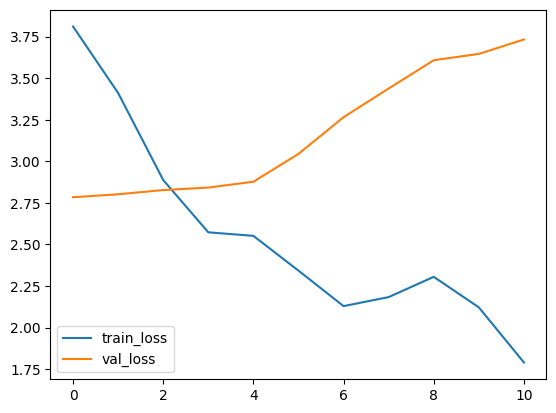

In [27]:
_ = log.plot()

In [28]:
model.partial_log_likelihood(*val).mean()

np.float32(-2.7838788)

## Prediction

However, as CoxPH is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

In [29]:
_ = model.compute_baseline_hazards()

#surv = model.predict_surv_df(x_test)
surv = model.predict_surv_df(X_test)

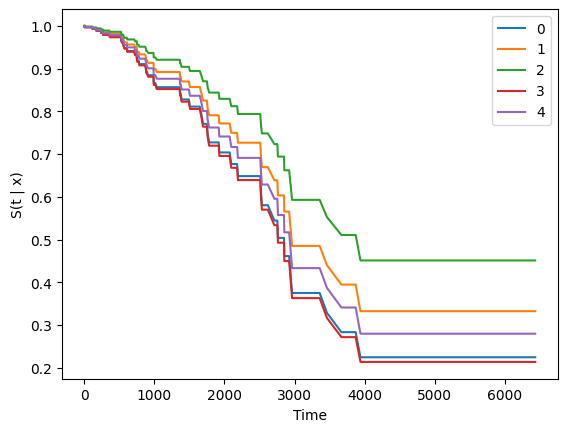

In [30]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [31]:
#ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev = EvalSurv(surv, y_test['durations'], y_test['events_test'], censor_surv='km')

In [32]:
ev.concordance_td()

0.489281210592686

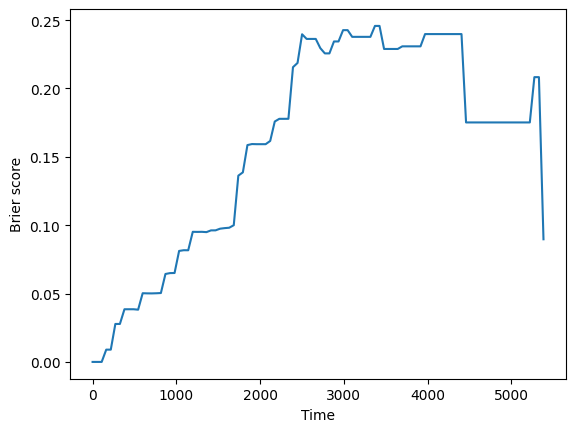

In [33]:
#time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid = np.linspace(y_test['durations'].min(), y_test['events_test'].max(), 100)
_ = ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

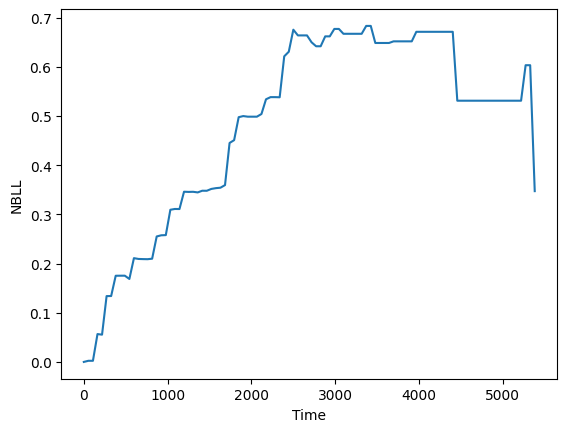

In [34]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score Graf et al. 1999. In practice this is done by numerical integration over a defined time_grid.

In [35]:
ev.integrated_brier_score(time_grid)

np.float64(0.16017628476075108)

In [36]:
ev.integrated_nbll(time_grid)

np.float64(0.4838034351753425)